In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import rc, rcParams

%matplotlib inline

rc('text', usetex=True)
font = {'family': 'Timer New Roman', 'weight': 'bold', 'size': 14 }
rc('font', **font)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

ipykernel_launcher:13: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [9]:
model_prop_val_map = {
    '0040000': 'r',
    '0050000': 'g',
    '0060000': 'b',
}
model_prop = 'c'

emb_loss_prop_val_map = {
    'none': None,
    'contrastive': None,
    'triplet': None,
}

solver_prop_val_map = {
    'original': '$',
    'feature_emb': None,
}

def rand_between(size, a, b):
    return (np.random.rand(size) * (b - a) + a).tolist()

n_vals = 12

models = ('0040000', '0050000', '0060000')
emb_losses = ('none', 'contrastive', 'triplet')
solvers = ('original', 'feature_emb')

data = {
    'mota': rand_between(n_vals, 68, 77),
    'motp': rand_between(n_vals, 13, 22),
    'model': [np.random.choice(models) for _ in range(n_vals)],
    'loss': [np.random.choice(emb_losses) for _ in range(n_vals)],
    'solver': [np.random.choice(solvers) for _ in range(n_vals)],
}

df = pd.DataFrame.from_dict(data)
df

,mota,motp,model,loss,solver
0,76.736820,18.240809,0050000,triplet,feature_emb
1,68.431612,21.526174,0040000,none,feature_emb
2,75.257251,17.408136,0050000,none,feature_emb
3,74.601387,17.881828,0060000,none,original
4,73.088643,16.536004,0060000,contrastive,original
5,73.914333,13.868320,0060000,none,original
6,73.965860,19.766279,0050000,none,original
7,71.520281,20.177548,0040000,triplet,original
8,71.729557,15.029574,0040000,none,original
9,69.321543,20.984409,0060000,contrastive,original


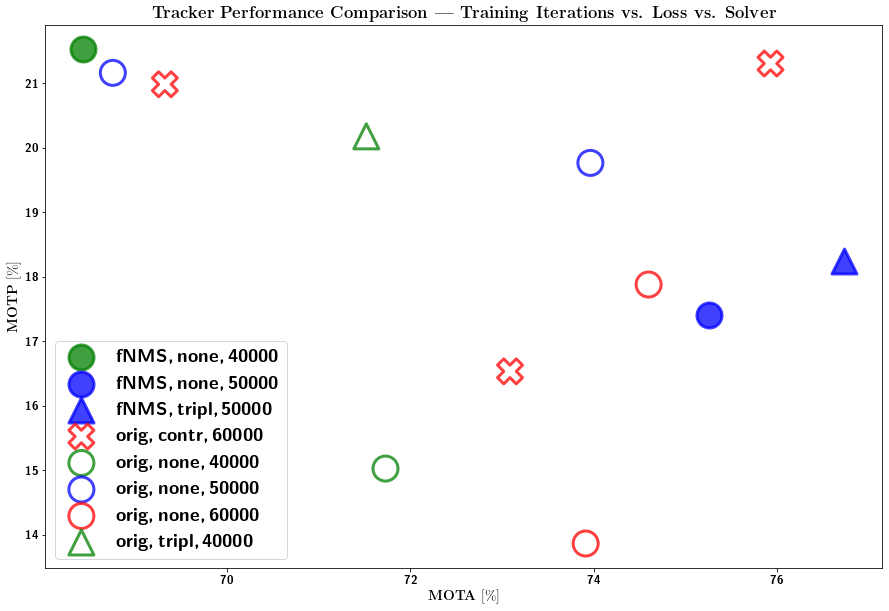

In [14]:
def plot_tracker_loss_solver_comparison(
    df, x_col, y_col, x_label, y_label, x_units='\%', y_units='\%'
):
    def _build_axis_label(text, units=None):
        label = rf'$\textbf{{{text}}}$'
        if units is not None:
            label += f' [{units}]'
        return label

    fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)

    base_colors =  list(mcolors.BASE_COLORS.keys())
    unique_models = df['model'].unique().tolist()

    size = 25 ** 2
    for solver, group_solver_df in df.groupby(['solver']):
        assert solver in ('original', 'feature_emb')

        if solver == 'original':
            facecolors = 'none'
            solver_text = 'orig'
        else:
            facecolors = edgecolors = None
            solver_text = 'fNMS'
        
        for loss, group_loss_df in group_solver_df.groupby(['loss']):
            assert loss in ('none', 'contrastive', 'triplet')
        
            if loss == 'none':
                marker = 'o'
                loss_text = 'none'
            elif loss == 'contrastive':
                marker = 'X'
                loss_text = 'contr'
            else:  # triplet
                marker = '^'
                loss_text = 'tripl'
        
            for model, group_model_df in group_loss_df.groupby(['model']):
                xs, ys = group_model_df[x_col], group_model_df[y_col]    
                
                model_text = str(int(model))
                curr_color = base_colors[unique_models.index(model)]
                label = rf'${solver_text}, {loss_text}, {model_text}$'
                if facecolors == 'none':
                    color = None
                    edgecolors = curr_color
                else:
                    color = curr_color
                
                ax.scatter(
                    xs, ys, s=size, c=color, label=label, marker=marker,
                    facecolors=facecolors, edgecolors=edgecolors, linewidth=4,
                    alpha=0.75
                )
    
    x_label_formatted = _build_axis_label(x_label, x_units)
    y_label_formatted = _build_axis_label(y_label, y_units)
    
    ax.set_title(
        r'$\textbf{Tracker Performance Comparison --- ' + 
        r'Training Iterations vs. Loss vs. Solver}$'
    )
    ax.set_xlabel(x_label_formatted)
    ax.set_ylabel(y_label_formatted)
    ax.legend(loc='lower left', prop={'size': 20})

    return fig

fig = plot_tracker_loss_solver_comparison(df, 'mota', 'motp', 'MOTA', 'MOTP')
fig.savefig('tracker_cmp_plot.png', dpi=300)

In [29]:
import pathlib
import shutil

def get_first_subdir_name(dir_path):
    return next(iter(dir_path.iterdir())).stem

def build_subdir_path(eval_dir):
    name = eval_dir.stem
    dataset, loss_token, solver_token, model = name.split('_')
    loss = loss_token.split('-')[1].replace(
        'contrastive', 'contr'
    ).replace(
        'triplet', 'tripl'
    )
    solver = solver_token.split('-')[1].replace(
        'featureemb', 'fNMS'
    ).replace(
        'original', 'orig'
    )
    model = model.replace('final', '0090000')
    tree_path = eval_dir.parent / dataset / loss / solver / model

    return tree_path

for eval_dir in pathlib.Path('./eval').iterdir():
    if '_' not in eval_dir.stem:
        continue

    subdir_name = get_first_subdir_name(eval_dir)
    src_eval_dir = eval_dir / subdir_name
    dst_eval_dir = build_subdir_path(eval_dir)
    dst_eval_dir.mkdir(parents=True, exist_ok=True)

    print(f"processing: {src_eval_dir} --> {dst_eval_dir}")

    shutil.move(str(src_eval_dir), str(dst_eval_dir))

processing: eval\uadt_loss-contrastive_slr-featureemb_0060000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\fNMS\0060000
processing: eval\uadt_loss-contrastive_slr-featureemb_0070000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\fNMS\0070000
processing: eval\uadt_loss-contrastive_slr-featureemb_0080000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\fNMS\0080000
processing: eval\uadt_loss-contrastive_slr-featureemb_final\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\fNMS\0090000
processing: eval\uadt_loss-contrastive_slr-original_0040000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\orig\0040000
processing: eval\uadt_loss-contrastive_slr-original_0050000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\orig\0050000
processing: eval\uadt_loss-contrastive_slr-original_0060000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\orig\0060000
processing: eval\uadt_loss-contrastive_slr-original_0070000\DLA-34-FPN_box_EMM_UA_DETRAC --> eval\uadt\contr\orig\0070000
processing: eval\u